### Exercise 1 Data based modeling and control

#### Imports

In [2]:
import scipy
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from control.matlab import tf, step, lsim


from utils import dbm_math



%matplotlib inline

#### Loading Matlab data 

In [3]:
mat_1 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data2_step.mat")
mat_2 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data1_step.mat")

for k in mat_1.keys():
    print(k)

for k in mat_2.keys():
    print(k)

__header__
__version__
__globals__
t2
u2
y2
__header__
__version__
__globals__
None
p
t
u
y
__function_workspace__


#### First look at data

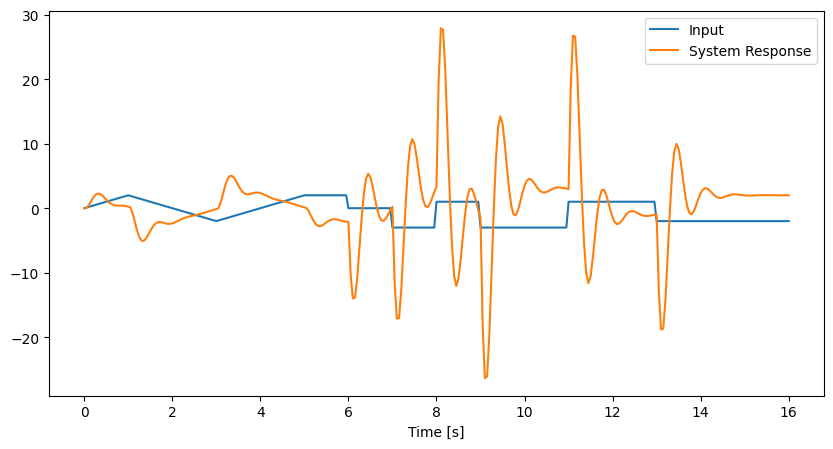

In [4]:
t2 = [e[0] for e in mat_1.get("t2").T]
u2 = [e[0] for e in mat_1.get("u2")]
y2 = [e[0] for e in mat_1.get("y2")]

plt.figure(figsize=(10, 5))
plt.plot(t2,u2, label="Input")
plt.xlabel("Time [s]")
plt.plot(t2, y2,label="System Response")
plt.legend()
plt.show()




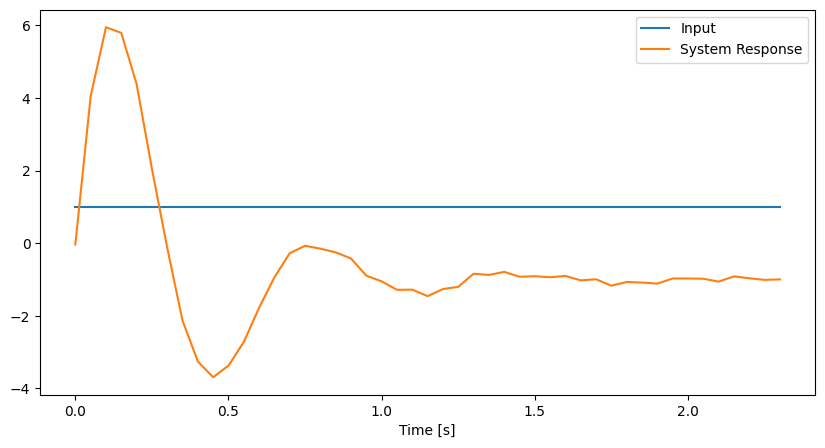

In [5]:
p = mat_2.get("p")
t = [e[0] for e in mat_2.get("t")]
u = [e[0] for e in mat_2.get("u")]
y = [e[0] for e in mat_2.get("y")]

plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()

#### Declaring constants

In [6]:
# Constants
Ts = 0.05
NA = 4
NB = 4

#### Creation of Model

In [7]:
y_jax = jnp.array(y)
u_jax = jnp.array(u)
y2_jax = jnp.array(y2)
u2_jax = jnp.array(u2)
S_K_3 = dbm_math.data_matrix(y_jax, u_jax, NA, NB)
SU2 = dbm_math.data_matrix(y2_jax, u2_jax, NA, NB)


In [8]:
p_hat:jax.Array = jnp.linalg.pinv(S_K_3) @ jnp.array(y)

In [ ]:
Gest = tf(p_hat[NA:].tolist(), [1] + list([-e for e  in p_hat[:NA].tolist()]), Ts)

y_test, test = step(Gest, T=t)
y_out, _, x_out = lsim(Gest, u2, T=t2)


y_out_arx = dbm_math.arx_sim(y_jax[:NA], u_jax,NA,NB,p_hat)

<TransferFunction>: sys[12]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-0.0397 z^4 + 4.102 z^3 - 0.1747 z^2 - 3.492 z - 0.8735
-------------------------------------------------------
   z^4 - 0.5153 z^3 - 0.5726 z^2 + 0.3858 z + 0.1783

dt = 0.05



/home/matthias/miniconda3/envs/python3.13/lib/python3.13/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


#### Plot Results of step response

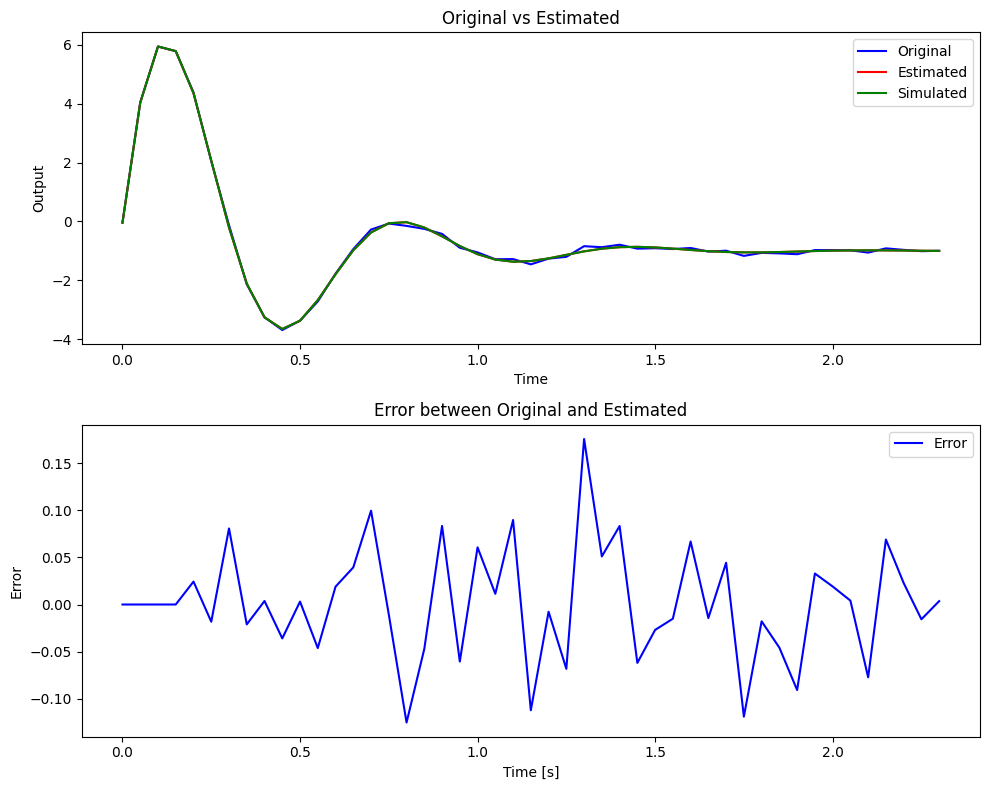

In [14]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))

ax[0].plot(t, y, 'b-', label='Original')
ax[0].plot(t, y_test, 'r-', label='Estimated')
ax[0].plot(t, y_out_arx, 'g-', label='Simulated')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Output')
ax[0].set_title('Original vs Estimated')

ax[1].plot(t, (y - y_test), 'b-', label='Error')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Error')
ax[1].set_title('Error between Original and Estimated')
plt.tight_layout()
plt.show()

#### Plot results of validation set

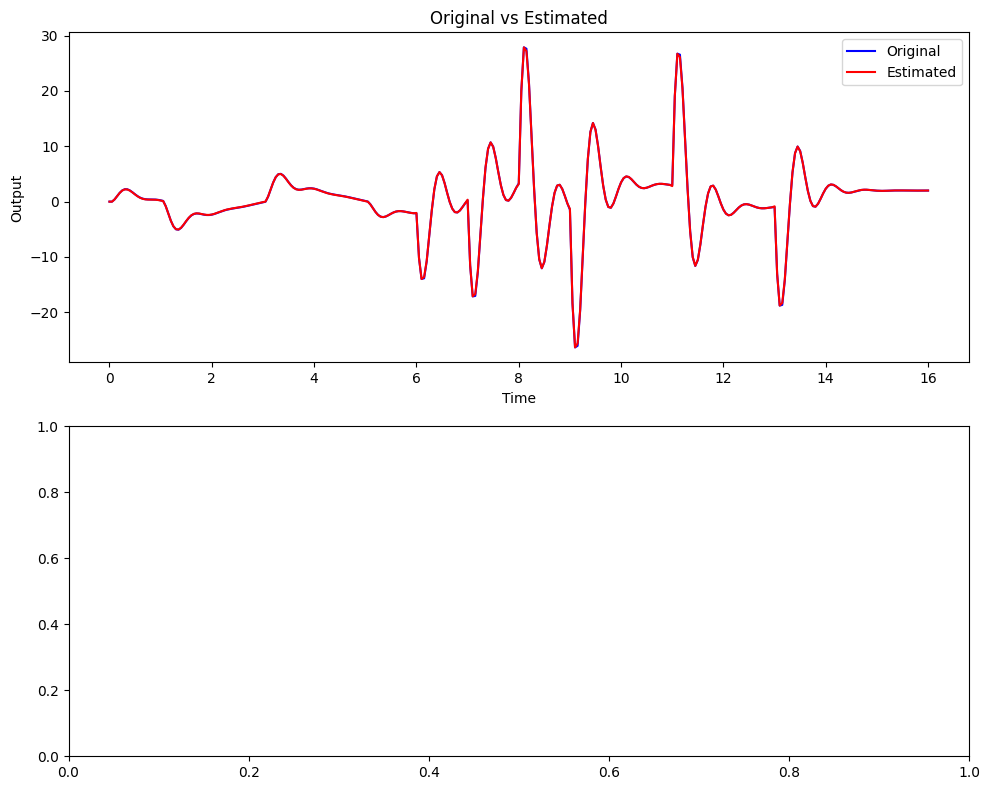

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(t2, y2, 'b-', label='Original')
axs[0].plot(t2, y_out, 'r-', label='Estimated')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Output')
axs[0].set_title('Original vs Estimated')

axs[1].plot(t, (y2 - y_out), 'b-', label='Error')
axs[1].legend()
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Error')
axs[1].set_title('Error between Original and Estimated')
plt.tight_layout()
plt.show()